In [242]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

import pcshrink

# Functions

In [243]:
def svd(Y, k):
    
    U, S, VT = svds(Y, k)

    # singular values
    S = np.diag(S[::-1])

    U, VT = svd_flip(U[:, ::-1], VT[::-1])

    V = VT.T
    
    return(U, S, V)

# Exploration

In [244]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 7.95 s, sys: 2.4 s, total: 10.3 s
Wall time: 7.48 s


In [245]:
Y = data.Y
p, n = Y.shape
print(p, n)

594924 777


In [213]:
norm = pcshrink.Normalizer(Y, .02, "patterson")

In [184]:
norm.s

array([[0.55165744],
       [0.5627535 ],
       [0.38129526],
       ...,
       [0.47800967],
       [0.65428793],
       [0.3130986 ]], dtype=float32)

In [216]:
norm.s.

(426765, 1)

Mean center

In [217]:
Z = Y[norm.snp_idx, :] - norm.mu
Z = (Z.T / norm.s.reshape(-1)).T
#Z = (Z.T / np.nanstd(Z, axis=1)).T
Z[np.isnan(Z)] = 0.0


In [218]:
p = norm.p_fil

In [219]:
ZtZ = (1. / norm.p) * Z.T @ Z

Scree plot

In [235]:
K = n-1
_, Lamb, V = svd(ZtZ, K)
Lamb.shape

(776, 776)

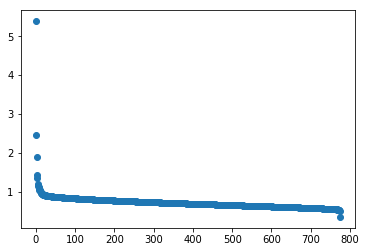

In [221]:
plt.scatter(np.arange(K), np.diag(Lamb))

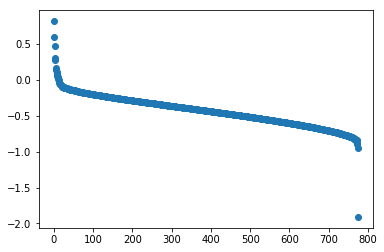

In [240]:
plt.scatter(np.arange(K), 1. / (np.diag(Lamb) / (np.diag(Lamb) - 1)))

Eigen decomp

In [222]:
K = 10
_, Lamb, V = svd(ZtZ, K)

S = np.diag(np.sqrt(np.diag(Lamb)))
S_inv = np.diag(1. / np.diag(S))

U = Z @ V @ S_inv 
F = U @ S
L = (F.T @ Z).T

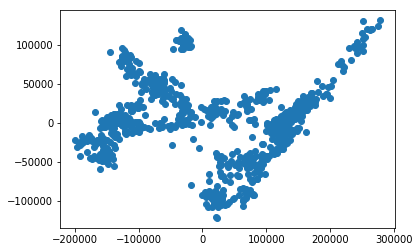

In [223]:
plt.scatter(L[:, 0], L[:, 1])

In [224]:
T = np.sum((1 / (n - K -1)) * (Z - Z @ (V @ V.T))**2, axis=1)
#tau = 1
tau = np.mean(T)
#tau


In [225]:
idx = np.ones(n, dtype="bool")
idx[67] = False
_, Lamb_h, V_h = svd(ZtZ[idx, :][:, idx], K)

S_h = np.diag(np.sqrt(np.diag(Lamb_h)))
S_inv_h = np.diag(1. / np.diag(S_h))

U_h = Z[:, idx] @ V_h @ S_inv_h 
F_h = U_h @ S_h 

l = F_h.T @ Z[:, ~idx]

#L_h = Z[:, idx] @ V_h
#Lamb_h_inv =  np.diag(1. / np.diag(Lamb_h))

In [226]:
lamb_h = np.diag(S_h)**2
infl = lamb_h / (lamb_h - tau)
infl

array([ 1.2247552,  1.6734608,  2.1133642,  3.1947763,  3.6435266,
        5.469737 ,  6.7996173,  8.375515 , 10.499641 , 14.3406925],
      dtype=float32)

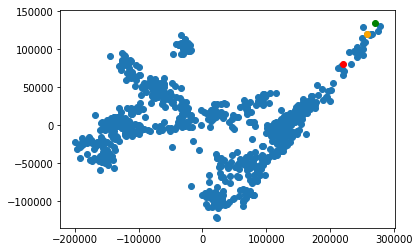

In [227]:
plt.scatter(L[:, 0], L[:, 1])
plt.scatter(L[~idx, 0], L[~idx, 1], c="orange")
plt.scatter(l[0], l[1], c="red")
plt.scatter(infl[0] * l[0], infl[1] * l[1], c="green")